In [1]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import autograd.numpy as np
from autograd import grad
from scipy.optimize import minimize
from scipy.stats import multivariate_normal
import autograd.numpy.random as npr
import sys, os
sys.path.append('..')
sys.path.append('../..')
from  viabel._distributions import  multivariate_t_logpdf
import autograd.scipy.stats.multivariate_normal as mvn
#import autograd.scipy.stats.multivariate_t as mvt


from paragami import (PatternDict,
                      NumericVectorPattern,
                      PSDSymmetricMatrixPattern,
                      FlattenFunctionInput)

from viabel.vb import (mean_field_gaussian_variational_family,
                       mean_field_t_variational_family,
                       t_variational_family,
                       black_box_klvi,
                       black_box_chivi,
                       make_stan_log_density,
                       _get_mu_sigma_pattern,
                       adagrad_optimize,
                       markov_score_climbing_cis
                      )

from experiments import plot_approx_and_exact_contours

sns.set_style('white')
sns.set_context('notebook', font_scale=2, rc={'lines.linewidth': 2})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [15]:
from psis import psislw

In [2]:
def plot_contours(means, covs, colors=None, xlim=[-10,10], ylim=[-3, 3], corr=None):
    xlist = np.linspace(xlim[0], xlim[1], 100)
    ylist = np.linspace(ylim[0], ylim[1], 100)
    X,Y = np.meshgrid(xlist, ylist)
    XY = np.concatenate([X[:,:,np.newaxis], Y[:,:,np.newaxis]], axis=2)
    colors = colors or sns.color_palette()
    for m, c, col in zip(means, covs, colors):
        Z = multivariate_normal.pdf(XY, mean=m, cov=c)
        plt.contour(X, Y, Z, colors=[col], linestyles='solid')
    if corr is not None:
        plt.title('correlation = {:.2f}'.format(corr))
        plt.savefig('../writing/variational-objectives/figures/kl-vb-corr-{:.2f}.pdf'.format(corr), 
                    bbox_inches='tight')
    plt.show()
    


In [3]:
def plot_approx_and_exact_contours(logdensity, var_family, var_param,colors=None, 
                                    xlim=[-2.5,2.5], ylim=[-3, 3],
                                    savepath=None, aux_var=None):
    xlist = np.linspace(*xlim, 100)
    ylist = np.linspace(*ylim, 100)
    X, Y = np.meshgrid(xlist, ylist)
    XY = np.concatenate([np.atleast_2d(X.ravel()), np.atleast_2d(Y.ravel())]).T
    if aux_var is not None:
        a1= XY.shape[0]
        XY = np.concatenate([XY, np.repeat(aux_var[None,:], a1, axis=0)], axis=1)
    zs = np.exp(logdensity(XY))
    Z = zs.reshape(X.shape)
    zsapprox = np.exp(var_family.logdensity(XY, var_param))
    Zapprox = zsapprox.reshape(X.shape)
    colors = colors or sns.color_palette()
    plt.contour(X, Y, Z, colors=[colors[0]], linestyles='solid')
    plt.contour(X, Y, Zapprox, colors=[colors[2]], linestyles='solid')
    if savepath is not None:
        plt.savefig(savepath, bbox_inches='tight')

    plt.show()


In [4]:
lims = dict(xlim=[-3,3], ylim=[-3,3])

In [18]:
def compute_inclusive_KL(m2, c2, var_family, optim_var_params, dim, n_samples=10000000, seed=40):
    L = np.linalg.cholesky(c2)
    my_rs = npr.RandomState(seed)
    samples = np.dot( my_rs.randn(n_samples, dim), L) + m2
    log_weights = mvn.logpdf(samples, m2, c2) - var_family.logdensity(samples, optim_var_params)
    _, paretok = psislw(log_weights)
    div = np.mean(log_weights)
    weights = np.exp(log_weights)
    div1 = -np.mean(weights*log_weights)
    print('reverse paretok:', paretok)
    return div, paretok

def compute_KL_estimate(m2, c2, var_family, optim_var_params, dim, n_samples=10000000, seed=40):
    samples = var_family.sample(optim_var_params, n_samples, seed)
    log_weights = mvn.logpdf(samples, m2, c2) - var_family.logdensity(samples, optim_var_params)
    _, paretok = psislw(log_weights)
    div = -np.mean(log_weights)
    print('kl paretok:', paretok)
    return div, paretok  

Average Loss = 3.3857: 100%|██████████| 3400/3400 [00:07<00:00, 428.01it/s]
/anaconda3/envs/viabel_env/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log1p
  return f_raw(*args, **kwargs)
/anaconda3/envs/viabel_env/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
../viabel/optimization_diagnostics.py:192: RuntimeWarning: invalid value encountered in greater_equal
  real_idxs = weights >= 10 * np.finfo(float).eps
../viabel/optimization_diagnostics.py:205: RuntimeWarning: divide by zero encountered in double_scalars
  sigma = -k_post / b_post
/anaconda3/envs/viabel_env/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)


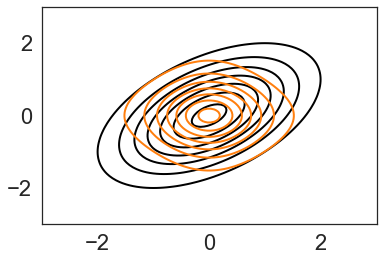

Average Loss = 3.9867: 100%|██████████| 3400/3400 [00:08<00:00, 402.07it/s]


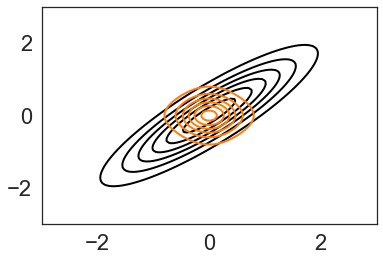

Average Loss = 4.3176: 100%|██████████| 3400/3400 [00:07<00:00, 448.42it/s]


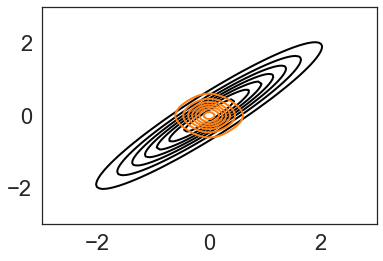

Average Loss = 5.2009: 100%|██████████| 3400/3400 [00:17<00:00, 197.27it/s]


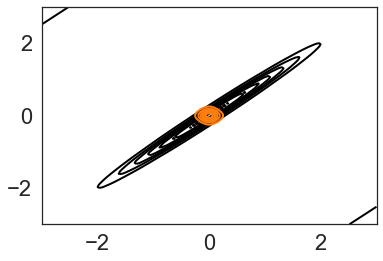

Average Loss = 166.27: 100%|██████████| 3400/3400 [02:19<00:00, 24.46it/s]


In [7]:
rhos = [.5, .88, .94, .99]


def _get_mu_sigma_pattern(dim):
    ms_pattern = PatternDict(free_default=True)
    ms_pattern['mu'] = NumericVectorPattern(length=dim)
    ms_pattern['Sigma'] = PSDSymmetricMatrixPattern(size=dim)
    return ms_pattern
# rhos.reverse()
ds = np.concatenate([np.arange(2,10,2), np.arange(10,105,30,dtype=int)]) # np.arange(2,11,2,dtype=int)
df = pd.DataFrame(columns=['corr', 'd', 'KL', 'KL2', 'paretok'])
inc_df = pd.DataFrame(columns=['corr', 'd', 'KL', 'KL2', 'paretok'])
n_iters = 10000

  


for rho in rhos:
    for d in ds:
        c2 = rho*np.ones((d,d))
        c2[np.diag_indices_from(c2)] = 1
        m2 = np.zeros(d)
    

        init_log_std = np.ones(d)*0.2   
        init_var_param1 = np.concatenate([m2, init_log_std])
        mf_t_var_family = mean_field_t_variational_family(d, df=6)
        
        ms_pattern = _get_mu_sigma_pattern(d)
        
        lnpdf2 = FlattenFunctionInput(
        lambda x: multivariate_t_logpdf(x, m2, c2, 100000),
        patterns=ms_pattern, free=True, argnums=1)
        lnpdf = lambda z: mvn.logpdf(z, m2, c2)
        #lnpdf_t = lambda z:
        
        klvi_objective_and_grad = black_box_klvi(mf_t_var_family, lnpdf, 2000)
        klvi_var_param,  klvi_param_history, value_history, grad_norm_history, oplog = \
        adagrad_optimize(3400, klvi_objective_and_grad, init_var_param1, learning_rate=.02, 
                                  learning_rate_end=0.001)
        if d == 2:
            #plot_contours(means=[m2, klvi_var_param[:d]], covs=[c2, np.diag(np.exp(klvi_var_param[d:]))], 
            #              colors=[(0.,0.,0.)]+sns.color_palette(),
            #              xlim=[-2.5,2.5], corr=rho)
            
            plot_approx_and_exact_contours(lnpdf, mf_t_var_family, klvi_var_param, colors=[(0.,0.,0.)]+sns.color_palette()+sns.color_palette(),**lims, savepath='../figures/klvi_gauss_vs_t_2D_'+str(rho)+'.pdf' )
        
        kl_val, paretok1 = compute_KL_estimate(m2, c2, mf_t_var_family, klvi_var_param, dim=d )
        df = df.append(dict(corr=rho, dimension=d, KL=value_history[-1], KL2 = kl_val, paretok=paretok1), ignore_index=True)
        inc_kl, paretok2 = compute_inclusive_KL(m2, c2, mf_t_var_family, klvi_var_param, dim=d )
        inc_df = inc_df.append(dict(corr=rho, dimension=d, KL=inc_kl, paretok=paretok2), ignore_index=True)

#### First we plot KL-divergence at the KLVI solution for increasing correlation and increasing dimensions

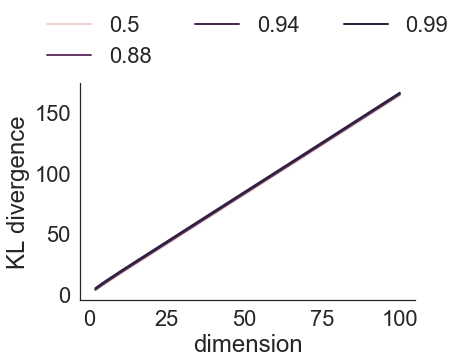

In [8]:
sns.lineplot(data=df, x='dimension', y='KL', hue='corr', legend='full')
#plt.legend(rhos, bbox_to_anchor=(1.04,1), loc="upper left")
plt.ylabel('KL divergence')
plt.legend(rhos, loc='upper center', bbox_to_anchor=(0.5, 1.4),
           ncol=3, frameon=False)
sns.despine()
plt.savefig('../writing/variational-objectives/figures/kl-gaussian_t_mean_field_kl.pdf', bbox_inches='tight')
plt.show()

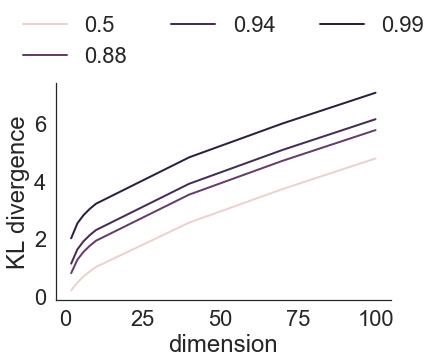

In [9]:
sns.lineplot(data=df, x='dimension', y='KL2', hue='corr', legend='full')
#plt.legend(rhos, bbox_to_anchor=(1.04,1), loc="upper left")
plt.ylabel('KL divergence')
plt.legend(rhos, loc='upper center', bbox_to_anchor=(0.5, 1.4),
           ncol=3, frameon=False)
sns.despine()
plt.savefig('../writing/variational-objectives/figures/kl-gaussian_t_mean_field_kl_2.pdf', bbox_inches='tight')
plt.show()

In [11]:
print(df)

    corr   d          KL       KL2  dimension
0   0.50 NaN    3.439706  0.202976        2.0
1   0.50 NaN    6.909435  0.477568        4.0
2   0.50 NaN   10.313987  0.689586        6.0
3   0.50 NaN   13.627227  0.865518        8.0
4   0.50 NaN   17.034430  1.020008       10.0
5   0.50 NaN   66.089003  2.563321       40.0
6   0.50 NaN  115.107867  3.728719       70.0
7   0.50 NaN  164.351163  4.796405      100.0
8   0.88 NaN    4.051225  0.803862        2.0
9   0.88 NaN    7.705254  1.271890        4.0
10  0.88 NaN   11.172908  1.548811        6.0
11  0.88 NaN   14.516885  1.757857        8.0
12  0.88 NaN   17.947452  1.932620       10.0
13  0.88 NaN   67.063946  3.538150       40.0
14  0.88 NaN  116.091406  4.712668       70.0
15  0.88 NaN  165.339032  5.784020      100.0
16  0.94 NaN    4.383819  1.134764        2.0
17  0.94 NaN    8.064796  1.631198        4.0
18  0.94 NaN   11.539513  1.915429        6.0
19  0.94 NaN   14.886724  2.127887        8.0
20  0.94 NaN   18.319528  2.304642

In [10]:
sns.lineplot(data=df, x='dimension', y='paretok', hue='corr', legend='full')
#plt.legend(rhos, bbox_to_anchor=(1.04,1), loc="upper left")
plt.ylabel('KL divergence')
plt.legend(rhos, loc='upper center', bbox_to_anchor=(0.5, 1.4),
           ncol=3, frameon=False)
sns.despine()
plt.savefig('../writing/variational-objectives/figures/kl-gaussian_t_mean_field_paretok.pdf', bbox_inches='tight')
plt.show()

ValueError: Could not interpret input 'paretok'

In [ ]:
sns.lineplot(data=inc_df, x='dimension', y='paretok', hue='corr', legend='full')
#plt.legend(rhos, bbox_to_anchor=(1.04,1), loc="upper left")
plt.ylabel('KL divergence')
plt.legend(rhos, loc='upper center', bbox_to_anchor=(0.5, 1.4),
           ncol=3, frameon=False)
sns.despine()
plt.savefig('../writing/variational-objectives/figures/kl-gaussian_t_mean_field_inc_paretok.pdf', bbox_inches='tight')
plt.show()

Average Loss = 0.15687: 100%|██████████| 5000/5000 [00:21<00:00, 231.84it/s]
/anaconda3/envs/viabel_env/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log1p
  return f_raw(*args, **kwargs)
/anaconda3/envs/viabel_env/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
../viabel/optimization_diagnostics.py:192: RuntimeWarning: invalid value encountered in greater_equal
  real_idxs = weights >= 10 * np.finfo(float).eps
../viabel/optimization_diagnostics.py:205: RuntimeWarning: divide by zero encountered in double_scalars
  sigma = -k_post / b_post
/anaconda3/envs/viabel_env/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)


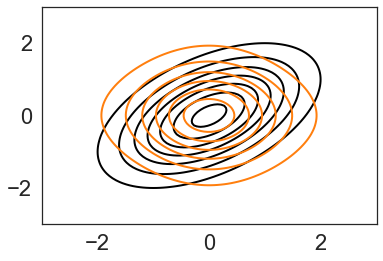

/Users/akashd/Desktop/research_repos/viabel/viabel/notebooks/psis.py:295: RuntimeWarning: overflow encountered in exp
  np.exp(temp, out=temp)
Average Loss = 8.8954:   0%|          | 0/5000 [00:00<?, ?it/s]

kl paretok: -0.3798404794150699
inc paretok: -0.4249828905538611


Average Loss = 9.218: 100%|██████████| 5000/5000 [01:29<00:00, 56.08it/s] 


kl paretok: 0.784648026812112


Average Loss = 18,905:   0%|          | 3/5000 [00:00<03:10, 26.25it/s]

inc paretok: 1.5892076609435708


Average Loss = 10.398: 100%|██████████| 5000/5000 [02:31<00:00, 33.04it/s]


kl paretok: 0.81508165208808


Average Loss = 5.2662e+07:   0%|          | 2/5000 [00:00<04:42, 17.68it/s]

inc paretok: 2.0972058262741604


Average Loss = 7.1578: 100%|██████████| 5000/5000 [03:40<00:00, 22.66it/s]    


kl paretok: 0.9097379629511103


Average Loss = 0.86721:   0%|          | 21/5000 [00:00<00:24, 205.19it/s]

inc paretok: 2.2050669882700693


Average Loss = 0.62426: 100%|██████████| 5000/5000 [00:21<00:00, 232.00it/s]


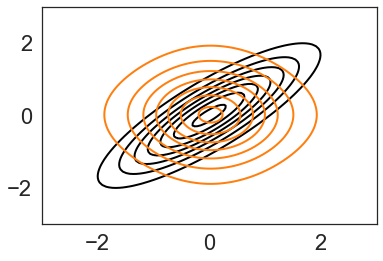

Average Loss = 4,279.4:   0%|          | 6/5000 [00:00<01:24, 59.16it/s]

kl paretok: 0.1230925929151428
inc paretok: 0.21357010603629406


Average Loss = 19.112: 100%|██████████| 5000/5000 [01:27<00:00, 57.21it/s]


kl paretok: 0.8587948184188154


Average Loss = 4.1024e+09:   0%|          | 4/5000 [00:00<02:41, 31.01it/s]

inc paretok: 1.18475288715493


Average Loss = 5.783: 100%|██████████| 5000/5000 [02:28<00:00, 33.57it/s]     


kl paretok: 0.9150204849528062


Average Loss = 3.3861e+15:   0%|          | 2/5000 [00:00<04:10, 19.98it/s]

inc paretok: 1.5608066762576334


Average Loss = 2.7257: 100%|██████████| 5000/5000 [03:47<00:00, 21.95it/s]    


kl paretok: 0.9317171089265563


Average Loss = 2.2403:   0%|          | 21/5000 [00:00<00:23, 208.77it/s]

inc paretok: 1.5191821308008486


Average Loss = 1.9716: 100%|██████████| 5000/5000 [00:22<00:00, 225.40it/s]


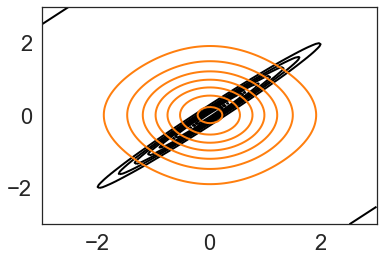

Average Loss = 3.4687e+10:   0%|          | 0/5000 [00:00<?, ?it/s]

kl paretok: 0.3160522868463548
inc paretok: 0.23235786844707781


Average Loss = 3.2227: 100%|██████████| 5000/5000 [01:31<00:00, 54.73it/s]    


kl paretok: 0.8759611783157224


Average Loss = 3.4547e+22:   0%|          | 4/5000 [00:00<02:33, 32.45it/s]

inc paretok: 0.7591574453431719


Average Loss = 0.88419: 100%|██████████| 5000/5000 [02:28<00:00, 33.60it/s]   
/anaconda3/envs/viabel_env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


kl paretok: 0.9106466541641067


Average Loss = 2.9757e+34:   0%|          | 3/5000 [00:00<03:39, 22.80it/s]

inc paretok: 1.8823116056760674


Average Loss = 0.69115: 100%|██████████| 5000/5000 [03:40<00:00, 22.64it/s]   


kl paretok: 0.9330704140081832
inc paretok: 1.0156946374210558


In [27]:
rhos = [0.50, .84, .99]
# rhos.reverse()
ds = np.concatenate([np.arange(2,40,10)]) # np.arange(2,11,2,dtype=int)
df1 = pd.DataFrame(columns=['corr', 'dimension', 'KL', 'paretok'])
inc_df1 = pd.DataFrame(columns=['corr', 'dimension', 'KL', 'paretok'])
n_iters = 5000
for rho in rhos:
    for d in ds:
        c2 = rho*np.ones((d,d))
        c2[np.diag_indices_from(c2)] = 1
        m2 = np.zeros(d)
        init_log_std = np.ones(d)*0.4  
        init_var_param1 = np.concatenate([m2, init_log_std])
        mf_t_var_family = mean_field_t_variational_family(d, df=10)
        lnpdf = lambda z: mvn.logpdf(z, m2, c2)
        incl_klvi_mf_objective_and_grad = markov_score_climbing_cis(mf_t_var_family, lnpdf, 4000,d)
        #lnpdf_t = lambda z:
        
        
        inc_klvi_var_param, inc_klvi_param_history, obj_history,  inc_klvi_history, op_log_inklvi = \
        adagrad_optimize(n_iters, incl_klvi_mf_objective_and_grad, init_var_param1, learning_rate=.01, learning_rate_end=0.001, has_log_norm=3,k=d)
        if d == 2:
            plot_approx_and_exact_contours(lnpdf, mf_t_var_family, inc_klvi_var_param, colors=[(0.,0.,0.)]+sns.color_palette()+sns.color_palette(), **lims)
        kl_val, paretok1 = compute_KL_estimate(m2, c2, mf_t_var_family, inc_klvi_var_param, dim=d )
        df1 = df1.append(dict(corr=rho, dimension=d, KL=value_history[-1], KL2 = kl_val, paretok=paretok1), ignore_index=True)
        inc_kl, paretok2 = compute_inclusive_KL(m2, c2, mf_t_var_family, inc_klvi_var_param, dim=d )
        inc_df1 = inc_df1.append(dict(corr=rho, dimension=d, KL=inc_kl, paretok=paretok2), ignore_index=True)
        #inc_kl = gaussianKL(m2, c2, m2, np.diag(np.exp(klvi_var_param[d:])) )
        #inc_df = inc_df.append(dict(corr=rho, dimension=d, KL=inc_kl), ignore_index=True)

#### Now we plot inclusive KL-divergence at the KLVI solution for increasing correlation and increasing dimensions

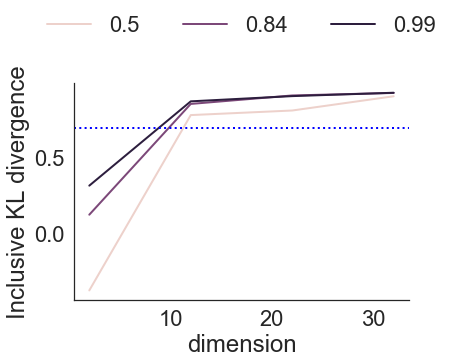

In [42]:
sns.lineplot(data=df1, x='dimension', y='paretok', hue='corr', legend='full')
#plt.legend(rhos, bbox_to_anchor=(1.04,1), loc="upper left")
plt.ylabel('Inclusive KL divergence')
plt.axhline(y=0.7, color='blue', linestyle=':')
plt.legend(rhos, loc='upper center', bbox_to_anchor=(0.5, 1.4),
           ncol=3, frameon=False)
sns.despine()
plt.savefig('../writing/variational-objectives/figures/inc_kl_soln_paretok_approx_vs_true.pdf', bbox_inches='tight')
plt.show()

#### Now we plot inclusive KL-divergence at the inclusive KLVI solution for increasing correlation and increasing dimensions

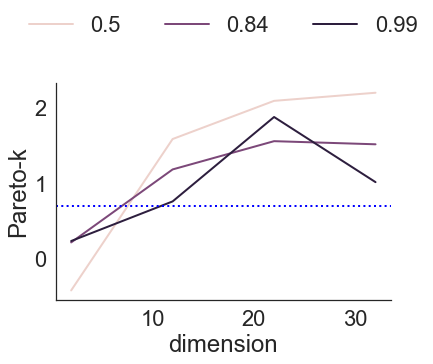

In [41]:
sns.lineplot(data=inc_df1, x='dimension', y='paretok', hue='corr', legend='full')
#plt.legend(rhos, bbox_to_anchor=(1.04,1), loc="upper left")
plt.ylabel('Pareto-k')
plt.axhline(y=0.7, color='blue', linestyle=':')
plt.legend(rhos, loc='upper center', bbox_to_anchor=(0.5, 1.4),
           ncol=3, frameon=False)
sns.despine()
plt.savefig('../writing/variational-objectives/figures/inc_kl_soln_paretok_true_vs_approx.pdf', bbox_inches='tight')
plt.show()

#### Now we plot KL-divergence at the inclusive KLVI solution for increasing correlation and increasing dimensions